# Test EV control

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ev_ssm import ev_ssm
from tqdm import tqdm
import scipy.stats as stats

In [ ]:
%run -i 'cosim_import.py'

caseH = 18
ict_off = False
ecc_off = False

%run -i 'cosim_setup_andes.py'

%run -i 'cosim_loadsyn.py'

%run -i 'cosim_setup_dispatch.py'

%run -i 'cosim_linktable.py'

# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 1.0, 1.0, 0.04

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Revise the EV control logic as: C->I, I->D, SOC high to low

In [1]:
# --- Response ---
from ev_ssm import ev_ssm
import numpy as np

sse = ev_ssm(ts=18, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA",
             n_pref=1, is_report=True,
             tt_mean=0.5, tt_var=0.2, tt_lb=0, tt_ub=1,
             ict_off=False, ecc_off=False)
sse.load_A("Aest.csv")

evd0 = sse.ev.copy()

# quiet some EVs by force
np.random.seed(sse.config["seed"])
ict_rid = np.random.randint(low=0,
                            high=sse.ev.shape[0],
                            size=3000)

sse.ev.na.iloc[ict_rid] = sse.ev.nam.iloc[ict_rid]
sse.ev.lc.iloc[ict_rid] = 1
sse.g_u()

# initial EV data
evd0 = sse.ev.copy()

sse.g_frc()

/home/jwang175/andes/jwang/notes/ev_ssm.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ev['na'].iloc[na_rid] = self.ev['nam'].iloc[na_rid]
/home/jwang175/andes/jwang/notes/ev_ssm.py:491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ev['lc'].iloc[na_rid] = 1
EVA: ts=18[H], 10000 EVs, Total Q=87.7 MWh
Online 2925, Q=73.03 MWh, SoC=0.7717
Power(MW): Pt=-7.9463, Pc=-7.9463, Pd=-0.0
Ctrl: 0=1584; 1=1341; 
EVA: Load A from Aest.csv.
/tmp/ipykernel_2836107/225252616.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

[4.383589795111681, 0.3360135637603187]

In [2]:
sse.run(tf=18 + 5/3600, Pi=0,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=False)

sse.run(tf=18 + 60/3600, Pi=10,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=False)

# sse.run(tf=18 + 100/3600, Pi=0,
#         is_updateA=False, is_rstate=True,
#         is_test=False, disable=False)

EVA MCS: 100%|██████████| 56/56 [00:17<00:00,  3.25it/s]


In [ ]:
self = sse
self.data["Per"] = self.data["Prc"] - self.data["Pr"]  # error of AGC response
self.data

In [5]:
u, v, us, vs, usp, vsp = sse.r_agc(5)

In [6]:
sse.data

{'ts': 18.016666666666723,
 'Pr': 5.0,
 'Prc': 4.389983505192177,
 'Per': 0,
 'ne': 2939,
 'nec': 1236,
 'Ptc': -3.5837989315588055,
 'Pcc': -7.714421250632543,
 'Pdc': 4.130622319073736,
 'Pt': -7.74210853687134}

In [ ]:
sse.data

In [4]:
sse.data

{'ts': 18.016666666666723,
 'Pr': 4.127276393812703,
 'Prc': 4.389983505192177,
 'Per': 0,
 'ne': 2939,
 'nec': 1236,
 'Ptc': -3.5837989315588055,
 'Pcc': -7.714421250632543,
 'Pdc': 4.130622319073736,
 'Pt': -7.74210853687134}

(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

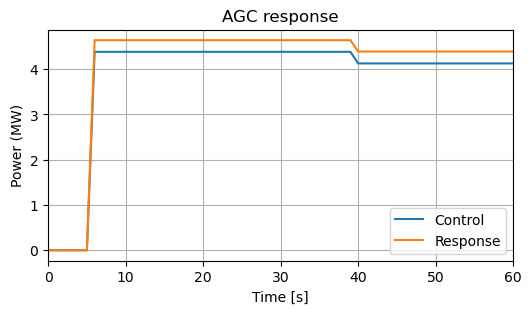

In [3]:
sse.plot_agc()

In [ ]:
sse.plot()

In [ ]:
sse.data

In [ ]:
sse.tsd.plot(y=['Pr', 'Prc', 'Per'])

In [ ]:
sse.tsd

In [ ]:
sse.plot_agc(tu='s')

In [ ]:
sse.run(tf=18 + 10/3600, Pi=0,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=False)

sse.run(tf=18 + 60/3600, Pi=10,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=False)
evd = sse.ev.copy()

In [ ]:
evd0[evd0['lc']==1][['u', 'c', 'c0', 'lc', 'na', 'nam']].head()
evd[evd['lc']==1][['u', 'c', 'c0', 'lc', 'na', 'nam']].head()

# row index of evd0 where lc == 1
lcrid = evd0[evd0['lc'] == 1].index

# compared dataframe
evdc = pd.DataFrame()
evdc['lc0'] = evd0['lc']
evdc['lc1'] = evd['lc']
evdc['c0'] = evd0['c']
evdc['c1'] = evd['c']
evdc['soc0'] = evd0['soc']
evdc['soc1'] = evd['soc']
evdc[evdc['lc0']==1][evdc['c0'] != evdc['c1']]

In [ ]:
# plt.plot(sse.Perl)

In [ ]:
sse.xtab.sum().sum()

In [ ]:
sse.nec

In [ ]:
sse.rtab.sum().sum()

In [ ]:
sse.x0.sum()

In [ ]:
sse.plot(tu='s')

In [ ]:
sse.ev['agc'].sum()

In [ ]:
sse.Prc

In [ ]:
sse.plot_agc(tu='s')

In [ ]:
# --- Response ---

# sse = ev_ssm(ts=10.4, N=10000, step=1, tp=40,
#              lr=0.1, lp=40, seed=2022, name="EVA")
# sse.load_A("Aest.csv")

t_list = [60 + 60 * i for i in list(range(7))]
p_list = [2, 0.05, 0.0, 1.0, -0.05, 1, 0]

x0 = sse.x0.copy()
print(sse.Prc)
for t, p in zip(t_list, p_list):
        sse.run(tf=18 + t/3600, Pi=p,
                is_updateA=False, is_rstate=True,
                is_test=False, disable=True)
print(sse.Prc)
x1 = sse.x0.copy()

In [ ]:
plt.plot(sse.tss, sse.Perl)

In [ ]:
sse.plot_agc()

In [ ]:
sse = ev_ssm(ts=10.4, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA",
             is_report=False)

# historical data
ev_num = pd.read_csv("ev_num.csv")

# calculate the sf
k1 = ev_num['ne'][(ev_num['time'] >= sse.ts) & (ev_num['time'] <= sse.ts+1/12)].mean()
k0 = ev_num['ne'][ev_num['time'] >= sse.ts].iloc[0]
k = k1 / k0

# estiamte FRC
sse.g_frc(nea=sse.ne*k)

In [ ]:
## Run to get the EV numbers within a day

# import joblib
# from joblib import Parallel, delayed

# Nt = 10000
# def rne(time):
#     sse1 = ev_ssm(ts=time, N=Nt, step=1, tp=40,
#                   lr=0.1, lp=60, seed=2022, name="EVA",
#                   is_report=False)
#     return sse1.ne

# # interval by minutes, 24H
# rnel = Parallel(n_jobs=joblib.cpu_count())(delayed(rne)(i) for i in np.arange(1/60, 24, 1/60))

# ev_num = pd.DataFrame()
# ev_num['time'] = np.arange(1/60, 24, 1/60)
# ev_num['ne'] = rnel
# ev_num.to_csv("ev_num.csv", index=False)